# 利用NVIDIA TensorRT加速交通环境感知
* 本次课程利用NVIDIA Transfer Learning Toolkit（后面使用TLT作为简称）训练模型，训练模型以及优化模型部分请参阅[TLT 开发者文档](https://docs.nvidia.com/metropolis/TLT/tlt-getting-started-guide/index.html)
* 本次课程针对有一定编程基础的开发者，需要对Python，深度学习，opencv等内容有一定了解
* 本次课程目标是利用NVIDIA TensorRT加速SSD-resnet18的交通目标检测模型，实现在图片，视频或者摄像头画面中检测出目标，并判断是哪一类
* 本次实验将道路标志分为四类，分别是交通标志(road_sign),汽车(vehicle),行人(pedestrian),两轮车(bicycle,包含自行车和摩托车)。
* 本次实验会提供基础的训练数据集，用于参赛队伍训练。但是，为了取得更好的成绩，需要对这个数据集需要进一步清理，扩展以及优化。
* 本次课程提供最基础的开发流程，以及相关工具和框架的使用方法，鼓励各位开发者在本教程的基础上做更多更好的优化。
* 本次课程实验作者需要以下实验环境:
  * **硬件平台**： NVIDIA Jetson NANO
  * **软件平台**： 
    1. NVIDIA Jetpack 4.4
    2. Ubuntu 18.04 L4T
    3. Python 3.6.9
    4. TensorRT 7.1
    5. CUDA 10.2
    6. Tensorflow 1.15
    7. NVIDIA Transfer Learning Toolkit 2.0
    8. Numpy 1.16.1
    9. Opencv 4.1.1
    10. Pytorch 1.6
    11. NeMo 1.0.0b3
    12. Numba 0.52.0
    


### TensorRT简介
* [NVIDIA TensorRT™](https://developer.nvidia.com/tensorrt)是一个用于高性能深度学习推理（inference）的SDK。它包括一个深度学习推理优化器和运行时加速库，为深度学习推理应用程序提供低延迟和高吞吐量。
* TensorRT现已能支持TensorFlow、Caffe、Mxnet、Pytorch等几乎所有的深度学习框架，将TensorRT和NVIDIA的GPU结合起来，能在几乎所有的框架中进行快速和高效的部署推理。
* TensorRT 是一个C++库，从 TensorRT 3 开始提供C++ API和Python API，主要用来针对 NVIDIA GPU进行 高性能推理（Inference）加速,现在最新版TensorRT 7.1。
* TensorRT 是专门用来做深度学习<font color=#008000 size=4>推理</font> 任务的,可以独立于训练框架使用。

![tensorrt](ipython_images/trt-info.png)

**TensorRT优化方法主要有以下几种方式：**
  1. 网络层的融合和张量融合  
     TensorRT通过对层间的横向或纵向合并，使得层的数量大大减少。横向合并可以把卷积、偏置和激活层合并成一个CBR结构，只占用一个CUDA核心。纵向合并可以把结构相同，但是权值不同的层合并成一个更宽的层，也只占用一个CUDA核心。
  2. 数据精度校准  
      大部分深度学习训练框架训练出来的模型的数据精度都是FP32，但是训练完的神经网络在推理阶段并不需要太大的精度范围，完全可以降低数据精度，比如：FP16或者INT8。低精度的数据类型会占用更少的存储空间，也会使模型的体积更小，加速推理和减少延迟。
  3. 自动内核调整  
      利用NVIDIA TensorRT优化的模型，可以自动的根据您的网络和GPU平台调整算法，设置CUDA kernel，保证当前的模型在您的GPU上以最优的性能进行计算。  
  4. 动态的Memory管理  
      在每个tensor的使用期间，TensorRT会为其指定显存，避免显存的重复申请以及浪费。  
  5. 多流执行  
      为多个输入的情况而设计，可以在多个CUDA Stream中使用多个TensorRT推理引擎，并行的执行多个输入，比如同时处理多路摄像头
  

### 利用NVIDIA NeMo对话式AI工具包实现语音识别
* 为了使活动更具丰富性，凸显语音语义与计算机视觉的结合应用，此处增加了基础的语音识别的部分。
* 本次实验将路标志分为四类，通过语音识别的方式，分别识别出指令为交通标志(road_sign),汽车(vehicle),行人(pedestrian),两轮车(bicycle,包含自行车和摩托车)。
* 本次实验会需要参赛队伍录制自己的语音数据，通过加载预训练模型实现基本的语音指令的识别功能。
* 本次课程提供最基础的开发流程，以及相关工具和框架的使用方法，鼓励各位开发者在本教程的基础上做更多更好的优化。

### NeMo简介
* NeMo是一个多模态对话式AI工具包集成(ASR-NLP-TTS)以Pytorch/Pytorch Lightning为后端，可以实现分布式训练混合精度计算，便于微调和迁移学习任务
* NeMo能够利用NVIDIA GPU上的Tensor Core核心，通过混合精度计算来获得最高性能。包括了将训练扩展到多GPU系统和多节点集群的功能
* NeMo使用户可以使用可重用的组件建立复杂的神经网络架构。利用神经类型，这些组件之间会自动进行语义兼容性检查
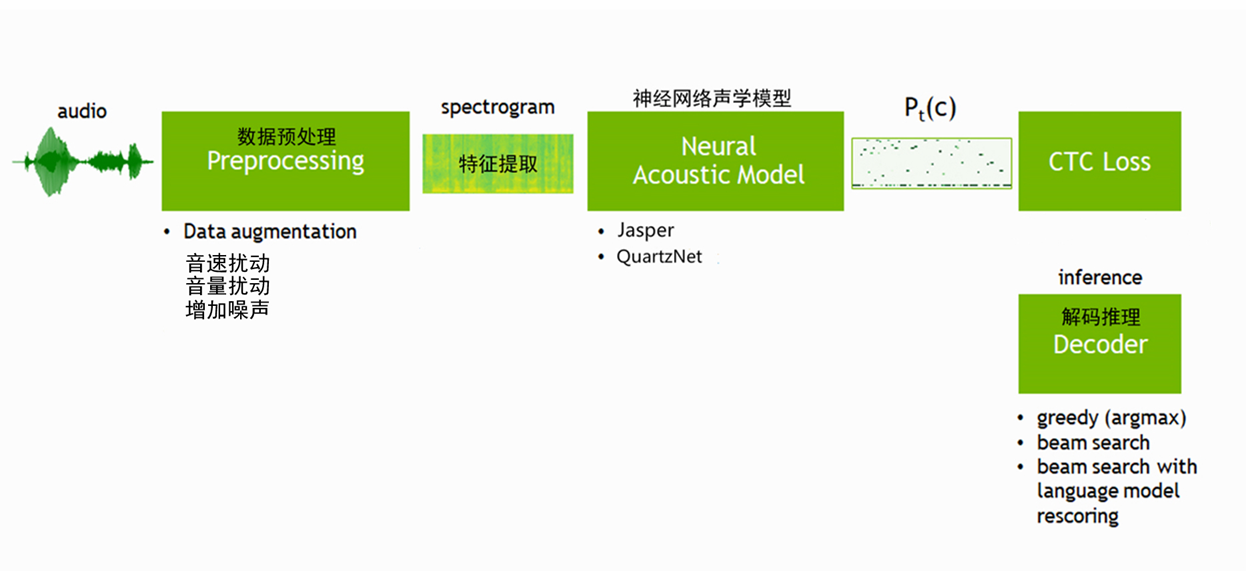


**下面我们讲用代码的形式说明如何利用TensorRT加速通过NVIDIA Transfer Learning训练的模型**

#### **1.导入需要的工具库**

In [17]:
#1
import sys
import time
import argparse
import cv2
import pycuda.autoinit  # This is needed for initializing CUDA driver
import numpy as np
from utils.ssd_classes import get_cls_dict
#from utils.ssd import TrtSSD
from utils.camera import add_camera_args, Camera
from utils.display import open_window, set_display, show_fps
from utils.visualization import BBoxVisualization
import ctypes
#import cv2
#import tensorflow as tf
import tensorrt as trt
import pycuda.driver as cuda

#### **2.设置图像预处理方法以及输出处理方法**

In [18]:
#2
def _preprocess_trt(img, shape=(300, 300)):
    """Preprocess an image before TRT SSD inferencing."""
    img = cv2.resize(img, shape)
    img = img.transpose((2, 0, 1)).astype(np.float32)
    return img


def _postprocess_trt(img, output, conf_th, output_layout):
    """Postprocess TRT SSD output."""
    img_h, img_w, _ = img.shape
    boxes, confs, clss = [], [], []
    #print(len(output))
    for prefix in range(0, len(output), output_layout):
        index = int(output[prefix+0])
        conf = float(output[prefix+2])
        if conf < conf_th:
            continue
        x1 = int(output[prefix+3] * img_w)
        y1 = int(output[prefix+4] * img_h)
        x2 = int(output[prefix+5] * img_w)
        y2 = int(output[prefix+6] * img_h)
        cls = int(output[prefix+1])
        boxes.append((x1, y1, x2, y2))
        confs.append(conf)
        clss.append(cls)
    return boxes, confs, clss

#### **3.设置并运行自动语音识别模块**

In [3]:
# # 无需执行 仅为演示用
# import numba
# numba.__version__
# import nemo
# import nemo.collections.asr as nemo_asr
# import gc
# import torch


# asr_model = nemo_asr.models.EncDecCTCModel.restore_from("QuartzNet15x5Base-Zh.nemo")
# wave_file1 = ["/home/nvidia/0_NVDC_Visual/asr_val/t_sbllc.wav"]
# result = asr_model.transcribe(paths2audio_files = wave_file1,batch_size=1)
# print(result)

# # first_asr_model.save_to("/home/nvidia/0_NVDC_Visual/asr_val") #save model to checkponitpath
# # first_asr_model.save_to("veer.nemo") # save model as .nemo format

# asr_model.save_to("/home/nvidia/0_NVDC_Visual/asr_val") #save model to checkponitpath
# asr_model.save_to("veer.nemo") # save model as .nemo format

# # upload model to jetson nano
# try_model_1 = nemo_asr.models.EncDecCTCModel.restore_from("/home/nvidia/0_NVDC_Visual/asr_val") # reload model from checkpoint path
# try_model_2 = nemo_asr.models.EncDecCTCModel.restore_from("/home/nvidia/0_NVDC_Visual/asr_val/veer.nemo") # reload model of .nemo

In [4]:
#3
asr_result = !python3 nemo_test.py
asr_result = (asr_result[-1].split('\'')[1])
print(asr_result)

识别行人


#### **4.利用tlt-converter工具将NVIDIA Transfer Learning Toolkit训练出来的模型转换成TensorRT推理引擎**
* 对于Jetson平台，您可以从[这里](https://developer.nvidia.com/tlt-converter-trt71)下载
* 在您使用tlt-converter工具之前，请您安装TensorRT OSS，详细步骤请参阅，[安装说明](https://docs.nvidia.com/metropolis/TLT/tlt-getting-started-guide/index.html#tensorrt_oss)
* 下面命令中的KEY是本节课使用的KEY，与作者训练出来的模型绑定，如果想使用自己训练的模型，请您前往[NGC官网](https://ngc.nvidia.com/catalog/)生成，并在Transfer Learning Toolkit中绑定
* 注意，这里可能需要花费稍微长点的时间

In [5]:
%set_env KEY=cTJhcms3ODdvbHRsOWwxMTNvYW0yN3NuaHA6NTcyNGExMmUtYTA2MC00MjAwLTkxNmYtNmVkZTc4NmJlZjky
!./tlt-converter -k $KEY \
               -d 3,384,1248 \
               -o NMS \
               -e ssd/TRT_ssd_resnet18_traffic.bin \
               -m 1 \
               -t fp32 \
               -i nchw \
               ssd/ssd_resnet18_epoch_020.etlt

env: KEY=cTJhcms3ODdvbHRsOWwxMTNvYW0yN3NuaHA6NTcyNGExMmUtYTA2MC00MjAwLTkxNmYtNmVkZTc4NmJlZjky
[INFO] Detected 1 inputs and 2 output network tensors.


#### **5.定义SSD-mobilenet v2模型的推理引擎的加载**
* 当我们已经优化好了引擎的时候，我们可以将优化好的引擎以文件的形式写到硬盘上，我们称之为序列化文件（serialized file）或PLAN文件
* 我们下次想直接使用优化好的引擎的时候，我们可以通过读取硬盘上的序列化文件，并利用 <font color=#008000 size=4>deserialize_cuda_engine() </font>方法进行反序列化，生成可执行的引擎
* 利用序列化文件生成可执行引擎可以为我们节省大量的时间
* 不同平台（软件或硬件平台）上生成的引擎的序列化文件不能直接通用，相同平台（软件且硬件平台）或同一台设备上生成的引擎序列化文件可以直接用
* 所以，上一步利用tlt-converter转换模型必须要在您运行的设备上执行
* NVIDIA Transfer Learning Toolkit训练生成的模型可以直接复制到其他设备平台，在这些设备上转换后可以直接被NVIDIA TensorRT和Deepstream使用

In [6]:
#4
class TrtSSD(object):
    """TrtSSD class encapsulates things needed to run TRT SSD."""
    #加载自定义组建，这里如果TensorRT版本小于7.0需要额外生成flattenconcat的自定义组件库
    def _load_plugins(self):
        if trt.__version__[0] < '7':
            ctypes.CDLL("ssd/libflattenconcat.so")
        trt.init_libnvinfer_plugins(self.trt_logger, '')
    #加载通过Transfer Learning Toolkit生成的推理引擎
    def _load_engine(self):
        TRTbin = 'ssd/TRT_%s.bin' % self.model
        with open(TRTbin, 'rb') as f, trt.Runtime(self.trt_logger) as runtime:
            return runtime.deserialize_cuda_engine(f.read())
    #通过加载的引擎，生成可执行的上下文
    def _create_context(self):
        for binding in self.engine:
            size = trt.volume(self.engine.get_binding_shape(binding)) * \
                   self.engine.max_batch_size
            ##注意：这里的host_mem需要时用pagelocked memory，以免内存被释放
            host_mem = cuda.pagelocked_empty(size, np.float32)
            cuda_mem = cuda.mem_alloc(host_mem.nbytes)
            self.bindings.append(int(cuda_mem))
            if self.engine.binding_is_input(binding):
                self.host_inputs.append(host_mem)
                self.cuda_inputs.append(cuda_mem)
            else:
                self.host_outputs.append(host_mem)
                self.cuda_outputs.append(cuda_mem)
        return self.engine.create_execution_context()
    #初始化引擎
    def __init__(self, model, input_shape, output_layout=7):
        """Initialize TensorRT plugins, engine and conetxt."""
        self.model = model
        self.input_shape = input_shape
        self.output_layout = output_layout
        self.trt_logger = trt.Logger(trt.Logger.INFO)
        self._load_plugins()
        self.engine = self._load_engine()

        self.host_inputs = []
        self.cuda_inputs = []
        self.host_outputs = []
        self.cuda_outputs = []
        self.bindings = []
        self.stream = cuda.Stream()
        self.context = self._create_context()
    #释放引擎，释放GPU显存，释放CUDA流
    def __del__(self):
        """Free CUDA memories."""
        del self.stream
        del self.cuda_outputs
        del self.cuda_inputs
    #利用生成的可执行上下文执行推理
    def detect(self, img, conf_th=0.3):
        """Detect objects in the input image."""
        img_resized = _preprocess_trt(img, self.input_shape)
        #print(img_resized.shape)
        np.copyto(self.host_inputs[0], img_resized.ravel())
        #将处理好的图片从CPU内存中复制到GPU显存
        cuda.memcpy_htod_async(
            self.cuda_inputs[0], self.host_inputs[0], self.stream)
        #开始执行推理任务
        self.context.execute_async(
            batch_size=1,
            bindings=self.bindings,
            stream_handle=self.stream.handle)
        #将推理结果输出从GPU显存复制到CPU内存
        cuda.memcpy_dtoh_async(
            self.host_outputs[1], self.cuda_outputs[1], self.stream)
        cuda.memcpy_dtoh_async(
            self.host_outputs[0], self.cuda_outputs[0], self.stream)
        self.stream.synchronize()


        output = self.host_outputs[0]
        #for x in output:
        #    print(str(x),end=' ')
        return _postprocess_trt(img, output, conf_th, self.output_layout)


**这里output输出每7个值为一组，分别是：**  
output[0]:  index  
output[1]:  class id  
output[2]:  confidence  
output[3]--output[6]:  bounding box  

#### **6.设置模型库**  
* 1.这里定义了多个模型库，我们选用的是**ssd_resnet18_traffic**
* 2.这里还定义了我们模型的输入（1248,384）

In [7]:
#5
INPUT_HW = (1248, 384)
SUPPORTED_MODELS = [
    'ssd_mobilenet_v1_coco',
    'ssd_mobilenet_v1_egohands',
    'ssd_mobilenet_v2_coco',
    'ssd_mobilenet_v2_egohands',
    'ssd_mobilenet_v2_face',
    'ssd_mobilenet_v2_signs',
    'ssd_resnet18_traffic'
]

  
  
#### **7.开始读取视频并将输出可视化的画到图像上**
* detect_one()方法是检测单张图片，detect_video()方法是检测视频
* 注意：这里打印的fps值是包括将图像写到结果视频中的时间，如果取消将视频写到结果视频的功能，速度会有大幅度提升

In [8]:
#6
def detect_video(video, trt_ssd, conf_th, vis,result_file_name, cls_id):
    full_scrn = False
    fps = 0.0
    tic = time.time()
    frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = video.get(cv2.CAP_PROP_FPS)
    #print(str(frame_width)+str(frame_height))
    ##定义输入编码
    fourcc = cv2.VideoWriter_fourcc('M', 'P', '4', 'V')
    videoWriter = cv2.VideoWriter('result.AVI', fourcc, fps, (frame_width,frame_height))
    ##开始循环检测，并将结果写到result.mp4中
    while True:
        ret,img = video.read()
        if img is not None:
            boxes, confs, clss = trt_ssd.detect(img, conf_th)
            if cls_id is not None:
                img = vis.draw_bboxes_one(img, boxes, confs, clss,cls_id)
            else:
                img = vis.draw_bboxes(img, boxes, confs, clss)
            videoWriter.write(img)
            toc = time.time()
            curr_fps = 1.0 / (toc - tic)
            fps = curr_fps if fps == 0.0 else (fps*0.95 + curr_fps*0.05)
            tic = toc
            print("\rfps: "+str(fps),end="")
        else:
            break

In [9]:
#7
def detect_one(img, trt_ssd, conf_th, vis, cls_id):
    full_scrn = False
    tic = time.clock()
    ##开始检测，并将结果写到result.jpg中
    boxes, confs, clss = trt_ssd.detect(img, conf_th)
    toc = time.clock()
    curr_fps = (toc - tic)
    print("boxes: "+str(boxes))
    print("clss: "+str(clss))
    print("confs: "+str(confs))
    if cls_id is not None:
        img = vis.draw_bboxes_one(img, boxes, confs, clss,cls_id)
    else:
        img = vis.draw_bboxes(img, boxes, confs, clss)
    cv2.imwrite("result.jpg",img)        
    print("time: "+str(curr_fps)+"(sec)")

In [10]:
#8
def asr_to_clsid(asr_result):
    if (asr_result == "识别自行车"):
        return 0
    elif (asr_result == "识别汽车"):
        return 1
    elif (asr_result == "识别行人"):
        return 2
    elif (asr_result == "识别路标"):
        return 3
    else:
        return None

#### **8.定义main()函数，检测单张图片**
* 学生可以自行上传图像到当前文件夹，并将filename请改成您要测试的图片的名字

In [11]:
#9
def main_one(asr_result):    
    filename = "traffic_1.jpg"
    result_file_name = str(filename)
    img = cv2.imread(filename)
    cls_dict = get_cls_dict("ssd_resnet18_traffic".split('_')[-1])
    model_name ="ssd_resnet18_traffic"
    trt_ssd = TrtSSD(model_name, INPUT_HW)
    vis = BBoxVisualization(cls_dict)
    cls_id = asr_to_clsid(asr_result)
#     cls_id = 4
    print(cls_id)
    print("start detection!")
    detect_one(img, trt_ssd, conf_th=0.35, vis=vis,cls_id=cls_id)
    cv2.destroyAllWindows()
    print("finish!")

model name: traffic
2
start detection!
boxes: [(508, 191, 585, 278), (370, 198, 426, 280), (579, 192, 610, 235), (0, 156, 236, 390), (418, 205, 463, 262), (676, 190, 731, 251), (638, 183, 684, 241), (618, 203, 641, 229), (450, 202, 479, 253), (272, 170, 389, 298), (402, 215, 426, 270), (466, 197, 492, 244), (716, 199, 739, 234)]
clss: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
confs: [0.5829699039459229, 0.5717259645462036, 0.563675582408905, 0.5543006062507629, 0.4601840376853943, 0.44169723987579346, 0.42715778946876526, 0.4067625403404236, 0.404828280210495, 0.3923417925834656, 0.384915292263031, 0.37421727180480957, 0.3734181225299835]
time: 0.05137099999999961(sec)
finish!


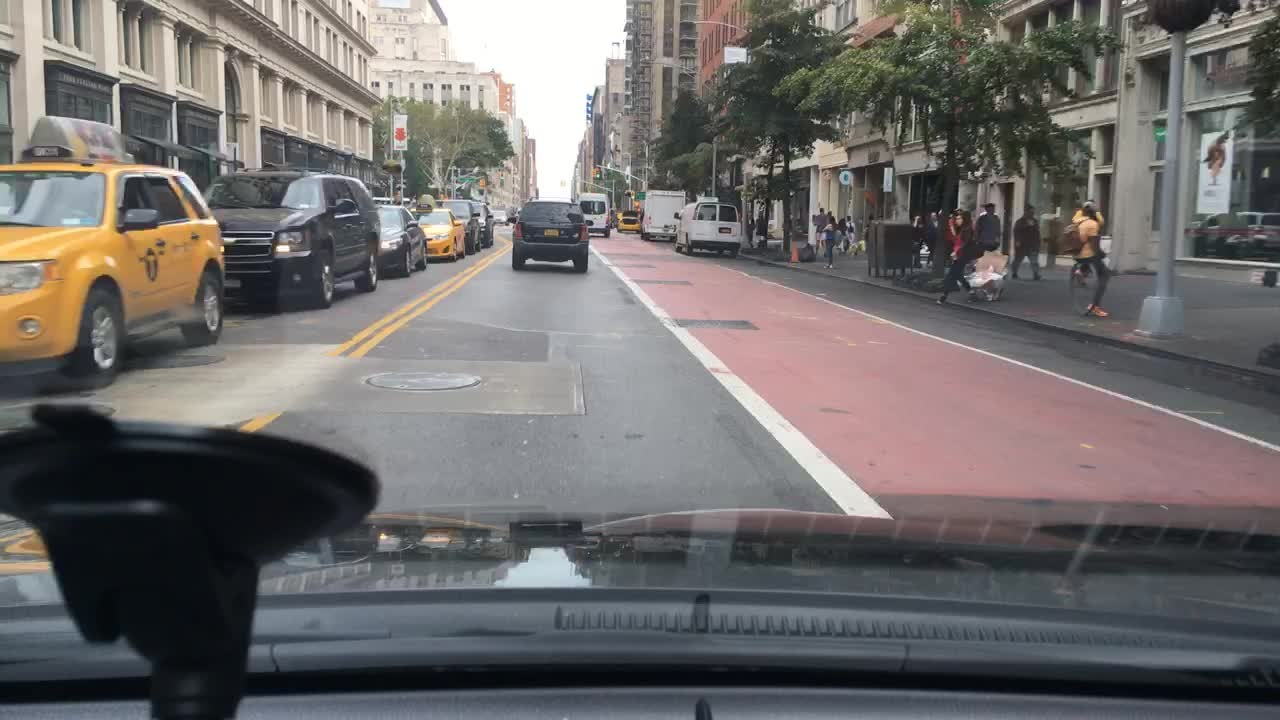

In [12]:
#10
from IPython.display import Image
main_one(asr_result)
Image("result.jpg")

#### **9.定义main()函数，检测视频**
* 学生可以自行上传视频到当前文件夹，并将filename请改成您要测试的视频的名字
* 检测视频部分由于要将检测的结果写到硬盘上，所以时间会加倍，如果要得到和单张检测相似的数据，可以将读写的语句注释掉

In [13]:
#11
def main_loop(asr_result):   
    filename = "video2.mp4"
    result_file_name = str(filename)
    video = cv2.VideoCapture(filename)
    cls_dict = get_cls_dict("ssd_resnet18_traffic".split('_')[-1])
    model_name ="ssd_resnet18_traffic"
    trt_ssd = TrtSSD(model_name, INPUT_HW)
    vis = BBoxVisualization(cls_dict)
    cls_id = cls_id = asr_to_clsid(asr_result)
#     cls_id = 1
    print("start detection!")
    detect_video(video, trt_ssd, conf_th=0.3, vis=vis, result_file_name=result_file_name,cls_id=cls_id)
    video.release()
    cv2.destroyAllWindows()
    print("\nfinish!")

In [14]:
#12
main_loop(asr_result)

model name: traffic
start detection!
fps: 12.094419011551248
finish!


#### **10.将生成的视频转码，以便能够在Jupyter Notebook中查看**
* 这里采用的是利用GPU加速的转码技术，将输出的视频转换到MP4格式，比单纯使用CPU进行转码的速度有大幅度提升

In [15]:
#13
!rm result-ffmpeg4.mp4
!ffmpeg -i result.AVI -vcodec libx264 -f mp4 result-ffmpeg4.mp4 

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu/Linaro 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/aarch64-linux-gnu --incdir=/usr/include/aarch64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --e

#### 11.查看结果视频

In [16]:
#14
from IPython.display import Video

Video("result-ffmpeg4.mp4")

### 课后总结
* 1.TensorRT是一个GPU推理引擎，能够利用NVIDIA GPU加速深度学习模型的推理。
* 2.NVIDIA Transfer Learning Toolkit是一个加速深度学习训练过程的工具包，包含迁移式学习，模型剪枝，模型训练等核心功能。能够直接输出支持NVIDIA TensorRT和Deepstream格式的模型。
* 3.结合TensorRT和Transfer Learning Toolkit两个工具，可以轻松地建立一个从数据到推理引擎的工作流程。
* 4.TensorRT支持目前常见的几乎所有框架训练出来的模型格式，用户也可以自行优化。
* 5.TensorRT推理引擎的创建，需要掌握一些CUDA相关的知识，为了让用户更加详细了解NVIDIA 生态工具，建议大家尝试学习CUDA。

### 课后扩展  
* 1.本次实验使用的是SSD-resnet18模型，模型本身比较轻量，大家可以考虑更换resnet其他模型或其他TLT支持的模型，提高检测精度
* 2.本次课程使用的数据集不大，模型最终的mPA为0.80，建议学生可以自己标注更多地数据集进行训练，提高检测精度
* 3.本次课程因为是远程的缘故处理的是本机的视频输入，学生可以自行更改，尝试使用CSI摄像头，rtsp摄像头或者web request等形式的图像输入
* 4.本次课程中涉及到的关于TensorRT和Transfer Learning Toolkit的视频内容资料，请访问[NVIDIA 开发者社区课程](https://www.nvidia.cn/developer/online-training/dli-community-training/)

### 比赛评分规则
本次比赛最终成绩由以下四部分组成：
* 1.模型推理精度（60%）：将最终提交的模型在NANO节点上进行推理，根据组委会提供的数据集得出推理结果并计算出mAP，所有队伍进行排名。精度部分的最终成绩为:
       accFinal = 60-(accRank-1)
* 2.模型速度（30%）：将最终提交的模型在NANO节点上进行推理，根据组委会提供的测试视频进行推理并计算出FPS，所有队伍进行排名。速度部分的最终成绩为：
       fpsFinal = 30-(fpsRank-1)*0.5
* 3.整体结构设计（5%）：如果在最终的测试中，能够重构推理部分的代码结构(将#3部分的代码重构或利用C/C++将其封装)，则最终成绩isRestructure加5分
* 4.网络模型重构（5%）：本教程提供的是ssd-resnet18的网络推理模型，如果能够更改代码利用其他模型进行推理，则最终成绩isOthermodel加5分（修改resnet18加3分，修改ssd加5分，如利用ssd-mobilenet则加3分，利用yolo-resnet18加5分）。

最终成绩为：Final = accFinal + fpsFinal + isRestructure + isOthermodel

![GTC](ipython_images/GTC.png)